In [2]:
import nomic
import json

api_key_path = "/home/paperspace/api_keys.json"

with open(api_key_path, 'r') as j:
    key = json.loads(j.read())['nomic']

nomic.login(key)
import numpy as np
import pandas as pd
from tqdm import tqdm

import transformers
from sentence_transformers import SentenceTransformer
import torch

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz
from unidecode import unidecode
import re
import datetime
import gc

dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-10-08')

df = dataset.maps[0].data.df
embds = dataset.maps[0].embeddings.latent

df_bill = pd.read_csv('/home/paperspace/congressional-twin/data/data/118-2024_h142.csv', header=1)
congress_name_list_bill=df_bill['matched-name'].unique()
congress_name_list_bill = [name for name in congress_name_list_bill if pd.notnull(name)][:-1]

df.head()

2024-10-17 19:13:36.683 | INFO     | nomic.dataset:__init__:761 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-10-08`.
2024-10-17 19:13:37.363 | WARNING  | nomic.data_operations:df:923 - Converting to pandas dataframe. This may materialize a large amount of data into memory.
2024-10-17 19:13:37.365 | INFO     | nomic.data_operations:_download_data:902 - Downloading data
100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 9716.01it/s]
2024-10-17 19:13:37.690 | INFO     | nomic.data_operations:_load_data:872 - Loading data
100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 177.93it/s]
2024-10-17 19:13:42.416 | INFO     | nomic.data_operations:_download_latent:550 - Downloading latent embeddings
100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 9692.51it/s]
2024-10-17 

,tweetId,postedAt,name,state,party,twitter_lower,chamber,years,source,id,text
0,1065633444502224896,2018-11-22 15:49:46.338,Ken Buck R-CO,CO,R,repkenbuck,House,2017_2018,PolitWoops,1203633,Happy #Thanksgiving! I hope everyone has a cha...
1,1479108462504136704,2022-01-06 15:11:52.624,Kat Cammack R-FL,FL,R,repkatcammack,House,2021_2022,PolitWoops,2857207,"RT @MorningsMaria: .@RepKatCammack: ""The Democ..."
2,85108215381102592,2011-06-26 22:12:34.438,Dennis Ross R-FL,FL,R,repdennisross,House,2011_2012,PolitWoops,35353,@CEP_Observer will have to check that out.
3,925691081026621440,2017-11-01 11:48:46.882,Richard Hudson R-NC,NC,R,reprichhudson,House,2017_2018,PolitWoops,954870,RT @BGClubCab: Thanks to @CharlotteWBB for hel...
4,1435963943533568000,2021-09-09 13:50:57.715,Chip Roy R-TX,TX,R,repchiproy,House,2021_2022,PolitWoops,2324693,RT @chiproytx: No. https://t.co/STZW0DdDz1


In [3]:
def capitalize_first_letters(name, delimiter=' '):
    recon=''
    chunks = name.split(delimiter)
    
    for chunk in chunks:
        recon += chunk[0].upper() + chunk[1:] + ' '
        
    return recon.strip()

def get_tweet_start(text, n_characters=30):
    chunks = text.split(' ')

    text_ = chunks[0]
    len_text = len(text_)

    c=1
    while len_text < n_characters and c < len(chunks)-1:
        text_ += ' ' + chunks[c]
        len_text = len(text_)
        c+=1

    return text_, len(chunks) - c

def remove_quotes(tweet, quote_list = ['"', "'", b'\xe2\x80\x9c'.decode()]):
    removed_first_quote = False
    while not removed_first_quote:
        if tweet in quote_list:
            tweet = tweet[1:]
        else:
            removed_first_quote=True

    removed_last_quote = False
    while not removed_first_quote:
        if tweet[-1] in quote_list:
            tweet = tweet[:-1]
        else:
            removed_last_quote=True
            
    if tweet[0] in quote_list:
        tweet = tweet[1:]
    if tweet[-1] in quote_list:
        tweet = tweet[:-1]
        
    return tweet.strip()

In [4]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="cuda:0",
)

embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
<All keys matched successfully>


In [6]:
# t = pd.Timestamp(year=2023, month=1, day=1)
t = pd.Timestamp(year=2017, month=7, day=28)

congress_name_list= list(df['name'].unique())    
name_to_standardized_name = {}

cp_metadata = {}

#- Add all congress persons in Atlas dataframe to name_to_standardized_name
for name in congress_name_list:
    key = name
    name = name.lower()
    chunks = name.split(' ')[:2]
    if ',' in chunks[0]:
        name = chunks[1] + '_' + chunks[0][:-1]
    else:
        name = chunks[0] + '_' + chunks[1]
        
    name_to_standardized_name[key] = unidecode(name)
    party=df[df['name'] == key]['party'].values[0]

    if key in congress_name_list_bill:
        vote = df_bill[df_bill['matched-name'] == key]['vote'].values[0]
    else:
        vote = 'n/a'
        
    cp_metadata[name] = {'party': party, 'vote': vote}
    
standardized_name_list = list(name_to_standardized_name.values())

n_congresspersons = len(congress_name_list)
all_text = {name: {'pre-t': [], 'post-t': []} for name in standardized_name_list}
all_embds = {name: {'pre-t': [], 'post-t': []} for name in standardized_name_list}

for i, embd in enumerate(tqdm(embds)):
    congress_name = name_to_standardized_name[df['name'][i]]
    posted_at = df['postedAt'][i]
    
    if posted_at > t:
        key='post-t'
    else:
        key='pre-t'
        
    all_text[congress_name][key].append(df['text'][i])
    all_embds[congress_name][key].append(embd)
    
for name in standardized_name_list:
    all_embds[name]['post-t'] = np.array(all_embds[name]['post-t'])
    all_embds[name]['pre-t'] = np.array(all_embds[name]['pre-t'])

100%|██████████████████████████████████████████████████████████████████████| 3214913/3214913 [00:59<00:00, 54325.03it/s]


In [7]:
## GPT-4o generation of questions for bill https://www.govtrack.us/congress/votes/115-2017/s179 

questions = [
    "What do you believe is the best approach to ensure universal access to affordable health care in the U.S.?",
    "How would you address the rising costs of prescription medications in a way that benefits both consumers and pharmaceutical companies?",
    "Do you support expanding Medicare or Medicaid, and why or why not?",
    "What role should the federal government play in regulating health insurance providers?",
    "How do you plan to balance the needs of health care providers with the financial constraints faced by patients, especially low-income families?",
    "What are your views on the role of private versus public health care options in the U.S. system?",
    "How do you plan to ensure that rural and underserved communities have access to quality health care services?",
    "What steps would you take to ensure that individuals with pre-existing conditions maintain access to affordable health care?",
    "Do you believe the U.S. should transition to a single-payer health care system? Why or why not?",
    "How would you address the ongoing debate about health care reform and its intersection with issues like mental health services, reproductive health, and senior care?"
]

embedded_questions = embedding_model.encode(questions)

In [8]:
np.random.seed(1)
shuffled_cps = np.random.choice(standardized_name_list, len(standardized_name_list), replace=False)

timeframes = ['pre-t', 'post-t']
sampled_tweet_dict = {}

name = 'morgan_griffith'
tweets = all_text[name]['post-t']
shuffled_tweets = np.random.choice(tweets, len(tweets), replace=False)
sampled_tweet_dict[name] = {'retrieved': {q: [] for q in questions}, 
                            'generated': {q: [] for q in questions},
}

n_cps = 500
for name in shuffled_cps:
    #- only consider n_cps congresspersons
    if len(sampled_tweet_dict) >= n_cps:
        break
        
    #- only consider congresspersons with enough tweets after t
    if len(all_text[name]['pre-t']) == 0:
        continue
        
    shuffled_tweets = np.random.choice(tweets, len(tweets), replace=False)
    sampled_tweet_dict[name] = {'retrieved': {q: [] for q in questions}, 
                                'generated': {q: [] for q in questions},
    }

sampled_name_list = list(sampled_tweet_dict.keys())
sampled_name_list[:10]

['morgan_griffith',
 'henry_cuellar',
 'ed_royce',
 'jared_huffman',
 'brian_mast',
 'jan_schakowsky',
 'billy_long',
 'marco_rubio',
 'gus_bilirakis',
 'jeff_duncan']

In [9]:
terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

pipeline.tokenizer.pad_token_id = pipeline.model.config.eos_token_id
pipeline.tokenizer.padding_side = 'left'

for name in tqdm(sampled_tweet_dict):
    proper_noun_name = capitalize_first_letters(name.replace('_', ' '))
    system_prompt = f"You are U.S. congressperson {proper_noun_name}."
    
    retrieved_tweet_indices = np.argmax(all_embds[name]['pre-t'] @ embedded_questions.T, axis=0)
                
    message_list = []
    for i,question in enumerate(questions):        
        retrieved_tweet = all_text[name]['pre-t'][retrieved_tweet_indices[i]]
        sampled_tweet_dict[name]['retrieved'][question] = retrieved_tweet

        user_prompt = f'Write a Tweet that addresses the following question: "{question}".'
        user_prompt += f' Here is an example Tweet potentially related to the to-be-completed Tweet: "{retrieved_tweet}".'
        user_prompt += ' Start your response with "Here is the full Tweet:".'

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]

        message_list.append(messages)

    outputs = pipeline(
        message_list,
        batch_size=50,
        max_new_tokens=64,
        eos_token_id=terminators,
        do_sample=True,
        temperature=1,
        num_return_sequences=5
    )
    
    for i,question in enumerate(questions):
        temp_outputs=outputs[i]
        sampled_tweet_dict[name]['generated'][question] = [o["generated_text"][-1]['content'] for o in temp_outputs]
        sampled_tweet_dict[name]['generated'][question] = [t.split('Here is the full Tweet:')[-1].strip() for t in sampled_tweet_dict[name]['generated'][question]]
        sampled_tweet_dict[name]['generated'][question] = [remove_quotes(t) for t in sampled_tweet_dict[name]['generated'][question]]

  2%|█▊                                                                                | 10/465 [01:15<56:49,  7.49s/it]/home/paperspace/venvs/pnma/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  9%|███████                                                                           | 40/465 [05:01<53:27,  7.55s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 18%|██████████████▍                                                                   | 82/465 [10:17<48:01,  7.52s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 27%|█████████████████████▌                                                           | 124/465 [15:33<42:55,  7.55s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 36%|████████████████████████████▉                                                    | 166/465 [20:50<37:27,  7.52s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 45%|████████████████████████████████████▏                                            | 208/465 [26:07<32:16,  7.54s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 54%|███████████████████████████████████████████▌                                     | 250/465 [31:23<26:59,  7.53s/it]


IndexError: string index out of range

In [10]:
import pickle
pickle.dump(sampled_tweet_dict, open('inference_tweet_dict.p', 'wb'))

In [11]:
try:
    pipline.model.to('cpu')
    embedding_model.to('cpu')
    del pipeline, embedding_model
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass
    
import pickle
sampled_tweet_dict = pickle.load(open('inference_tweet_dict.p', 'rb'))
embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

<All keys matched successfully>


In [20]:
_sampled_tweet_dict = {}
for name in sampled_tweet_dict:
    empty = False
    for type_ in sampled_tweet_dict[name]:
        for question in questions:
            if len(sampled_tweet_dict[name][type_][question]) == 0:
                empty=True
    if not empty:
        _sampled_tweet_dict[name] = sampled_tweet_dict[name].copy()
sampled_tweet_dict=_sampled_tweet_dict.copy()

In [19]:
name

'mike_'

In [21]:
matrix_representations = {}

for name in sampled_tweet_dict:
    matrix_representations[name] = {}
    
    matrix_representations[name]['retrieved'] = list(sampled_tweet_dict[name]['retrieved'].values())
    matrix_representations[name]['retrieved'] = embedding_model.encode(matrix_representations[name]['retrieved'])
    
    matrix_representations[name]['generated'] = []
    for question in questions:
        temp = sampled_tweet_dict[name]['generated'][question]
        temp = embedding_model.encode(temp)
        matrix_representations[name]['generated'].append(np.mean(temp, axis=0))
        
    matrix_representations[name]['generated'] = np.array(matrix_representations[name]['generated'])

In [22]:
name_list = list(sampled_tweet_dict.keys())
dist_matrix_retrieved = np.zeros((len(name_list), len(name_list)))
dist_matrix_generated = np.zeros((len(name_list), len(name_list)))

for i, name1 in enumerate(name_list):
    for ii, name2 in enumerate(name_list[i+1:], i+1):
        dist_matrix_retrieved[i, ii] = np.linalg.norm(matrix_representations[name1]['retrieved'] - matrix_representations[name2]['retrieved'])
        dist_matrix_retrieved[ii, i] = dist_matrix_retrieved[i, ii]
    
        dist_matrix_generated[i, ii] = np.linalg.norm(matrix_representations[name1]['generated'] - matrix_representations[name2]['generated'])
        dist_matrix_generated[ii, i] = dist_matrix_generated[i, ii]

In [23]:
from graspologic.embed import ClassicalMDS

cmds_generated = ClassicalMDS().fit_transform(dist_matrix_generated)
cmds_retrieved = ClassicalMDS().fit_transform(dist_matrix_retrieved)

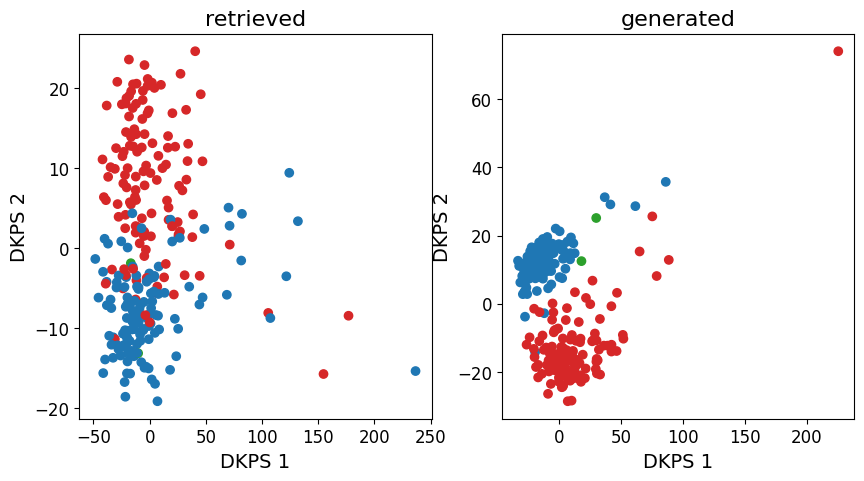

In [26]:
from graspologic.plot import pairplot, heatmap

party_list = [cp_metadata[name]['party'] for name in sampled_tweet_dict]
party_color_dict = {'D': 'tab:blue', 'R': 'tab:red', 'I': 'tab:green'}

vote_list = [cp_metadata[name]['vote'] for name in sampled_tweet_dict]
vote_color_dict = {'Nay': 'tab:red', 'Yea': 'tab:green', 'Not Voting': 'tab:olive', 'n/a': 'k'}

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].scatter(cmds_retrieved[:, 0], cmds_retrieved[:, 1], c=[party_color_dict[p] for p in party_list])
axs[0].set_title('retrieved', fontsize=16)

axs[1].scatter(cmds_generated[:, 0], cmds_generated[:, 1], c=[party_color_dict[p] for p in party_list])
axs[1].set_title('generated', fontsize=16)

for ax in axs:
    ax.tick_params(labelsize=12)
    ax.set_xlabel('DKPS 1', fontsize=14)
    ax.set_ylabel('DKPS 2', fontsize=14)

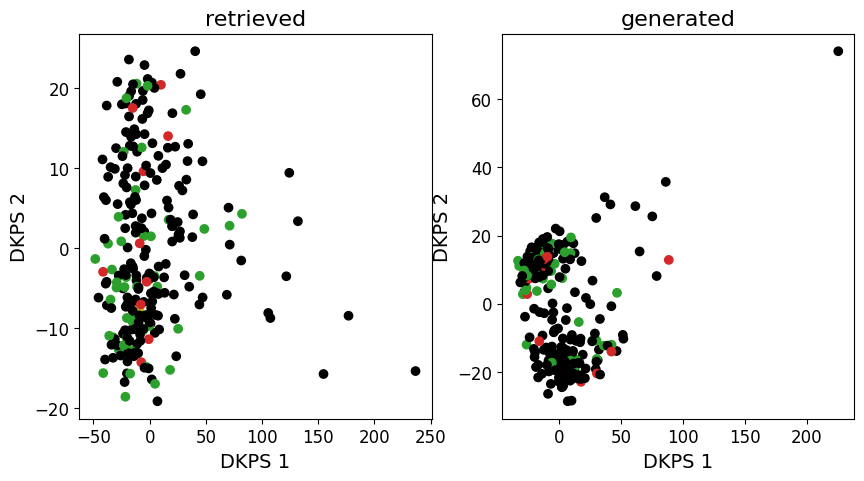

In [27]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].scatter(cmds_retrieved[:, 0], cmds_retrieved[:, 1], c=[vote_color_dict[v] for v in vote_list])
axs[0].set_title('retrieved', fontsize=16)

axs[1].scatter(cmds_generated[:, 0], cmds_generated[:, 1], c=[vote_color_dict[v] for v in vote_list])
axs[1].set_title('generated', fontsize=16)

for ax in axs:
    ax.tick_params(labelsize=12)
    ax.set_xlabel('DKPS 1', fontsize=14)
    ax.set_ylabel('DKPS 2', fontsize=14)